In [14]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import pandas as pd


df = pd.read_csv('../data/cleanedData.csv')
existingCustomers = pd.read_excel('../data/Clustered Data.xlsx')
nonExistingCustomers = df[~df['PBKEY'].isin(existingCustomers['PBKEY'])]

In [3]:
print("Shape of all the addresses:", df.shape[0])
print("Shape of all the addresses which are already a customers:", existingCustomers.shape[0])
print("Shape of all the addresses which are not our customers:", nonExistingCustomers.shape[0])

Shape of all the addresses: 55354
Shape of all the addresses which are already a customers: 1833
Shape of all the addresses which are not our customers: 53523


In [9]:
nonExistingCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53523 entries, 0 to 55353
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   psyte_PSYTECategoryCode                       53523 non-null  float64
 1   psyte_PSYTEGroupCode                          53523 non-null  object 
 2   psyte_censusBlock                             53523 non-null  float64
 3   psyte_censusBlockGroup                        53523 non-null  float64
 4   psyte_censusBlockPopulation                   53523 non-null  float64
 5   psyte_censusBlockHouseholds                   53523 non-null  float64
 6   psyte_PSYTESegmentCode.description            53523 non-null  object 
 7   psyte_householdIncomeVariable.value           53523 non-null  object 
 8   psyte_householdIncomeVariable.description     53523 non-null  object 
 9   psyte_propertyValueVariable.value             53523 non-null  obje

In [10]:
def identify_cluster0_potential(df):
    """Identify potential customers matching Cluster 0 characteristics"""
    return df[
        # Age above middle & urban
        (df['psyte_urbanRuralVariable.description'].str.contains('urban', case=False, na=False)) &
        # Property ownership
        (df['psyte_propertyTenureVariable.description'].str.contains('owned', case=False, na=False)) &
        # Single family residences
        (df['psyte_propertyTypeVariable.description'].str.contains('single', case=False, na=False))
    ]

def identify_cluster1_potential(df):
    """Identify potential customers matching Cluster 1 characteristics"""
    return df[
        # Urban areas
        (df['psyte_urbanRuralVariable.description'].str.contains('urban', case=False, na=False)) &
        # Rental properties
        (df['psyte_propertyTenureVariable.description'].str.contains('rent', case=False, na=False)) &
        # Single family homes
        (df['psyte_propertyTypeVariable.description'].str.contains('single', case=False, na=False))
    ]

def identify_cluster2_potential(df):
    """Identify potential customers matching Cluster 2 characteristics"""
    return df[
        # Urban areas
        (df['psyte_urbanRuralVariable.description'].str.contains('urban', case=False, na=False)) &
        # Rental properties
        (df['psyte_propertyTenureVariable.description'].str.contains('rent', case=False, na=False)) &
        # Townhouses or mixed properties
        (df['psyte_propertyTypeVariable.description'].str.contains('town|mixed', case=False, na=False))
    ]

def identify_cluster3_potential(df):
    """Identify potential customers matching Cluster 3 characteristics"""
    return df[
        # Rural areas
        (df['psyte_urbanRuralVariable.description'].str.contains('rural', case=False, na=False)) &
        # Mortgaged properties
        (df['psyte_propertyTenureVariable.description'].str.contains('mortgage', case=False, na=False)) &
        # Single family or manufactured homes
        (df['psyte_propertyTypeVariable.description'].str.contains('single|manufactured', case=False, na=False))
    ]

def identify_cluster4_potential(df):
    """Identify potential customers matching Cluster 4 characteristics"""
    return df[
        # Urban areas
        (df['psyte_urbanRuralVariable.description'].str.contains('urban', case=False, na=False)) &
        # Rental properties
        (df['psyte_propertyTenureVariable.description'].str.contains('rent', case=False, na=False)) &
        # Townhouses
        (df['psyte_propertyTypeVariable.description'].str.contains('town', case=False, na=False))
    ]

def analyze_panama_city_potential(df):
    """Analyze potential customers in Panama City across all clusters"""
    # Filter for Panama City
    panama_city_df = df[df['CITY'].str.contains('Panama City', case=False, na=False)]
    
    # Identify potential customers for each cluster
    cluster_potentials = {
        'Cluster 0': identify_cluster0_potential(panama_city_df),
        'Cluster 1': identify_cluster1_potential(panama_city_df),
        'Cluster 2': identify_cluster2_potential(panama_city_df),
        'Cluster 3': identify_cluster3_potential(panama_city_df),
        'Cluster 4': identify_cluster4_potential(panama_city_df)
    }
    
    # Calculate summary statistics
    summary = {
        cluster: {
            'count': len(data),
            'avg_living_sqft': data['LivingSquareFootage'].mean(),
            'avg_sale_amount': data['SaleAmount'].mean(),
            'property_types': data['psyte_propertyTypeVariable.description'].value_counts().to_dict(),
            'income_levels': data['psyte_householdIncomeVariable.description'].value_counts().to_dict()
        }
        for cluster, data in cluster_potentials.items()
    }
    
    return cluster_potentials, summary

# Function to identify unserved segments
def identify_unserved_segments(df, cluster_potentials):
    """Identify addresses that don't fit into any existing cluster"""
    # Combine all clustered addresses
    all_clustered = pd.concat([pot for pot in cluster_potentials.values()])
    
    # Find unserved addresses
    unserved = df[~df.index.isin(all_clustered.index)]
    
    # Analyze characteristics of unserved segments
    unserved_analysis = {
        'count': len(unserved),
        'property_types': unserved['psyte_propertyTypeVariable.description'].value_counts().to_dict(),
        'income_levels': unserved['psyte_householdIncomeVariable.description'].value_counts().to_dict(),
        'urban_rural': unserved['psyte_urbanRuralVariable.description'].value_counts().to_dict()
    }
    
    return unserved, unserved_analysis


Potential Customer Analysis by Cluster:
--------------------------------------------------

Cluster 0:
Number of potential customers: 19325
Average living space: 2333.10 sq ft
Average property value: $1,740,591.84

Top Property Types:
- Majority of properties single family residences: 19325

Top Income Levels:
- Top 30-50% of households by household income: 6273
- Bottom 30-49.99% of households by household income: 4743
- Bottom 10-19.99% of households by household income: 2805

Cluster 1:
Number of potential customers: 9343
Average living space: 18313.46 sq ft
Average property value: $2,819,671.03

Top Property Types:
- Majority of properties single family residences: 9343

Top Income Levels:
- Bottom 30-49.99% of households by household income: 2520
- Bottom 10-19.99% of households by household income: 2052
- Bottom 9.99% of households by household income: 1954

Cluster 2:
Number of potential customers: 5490
Average living space: 23434.01 sq ft
Average property value: $1,140,770.44


/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/4197111007.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


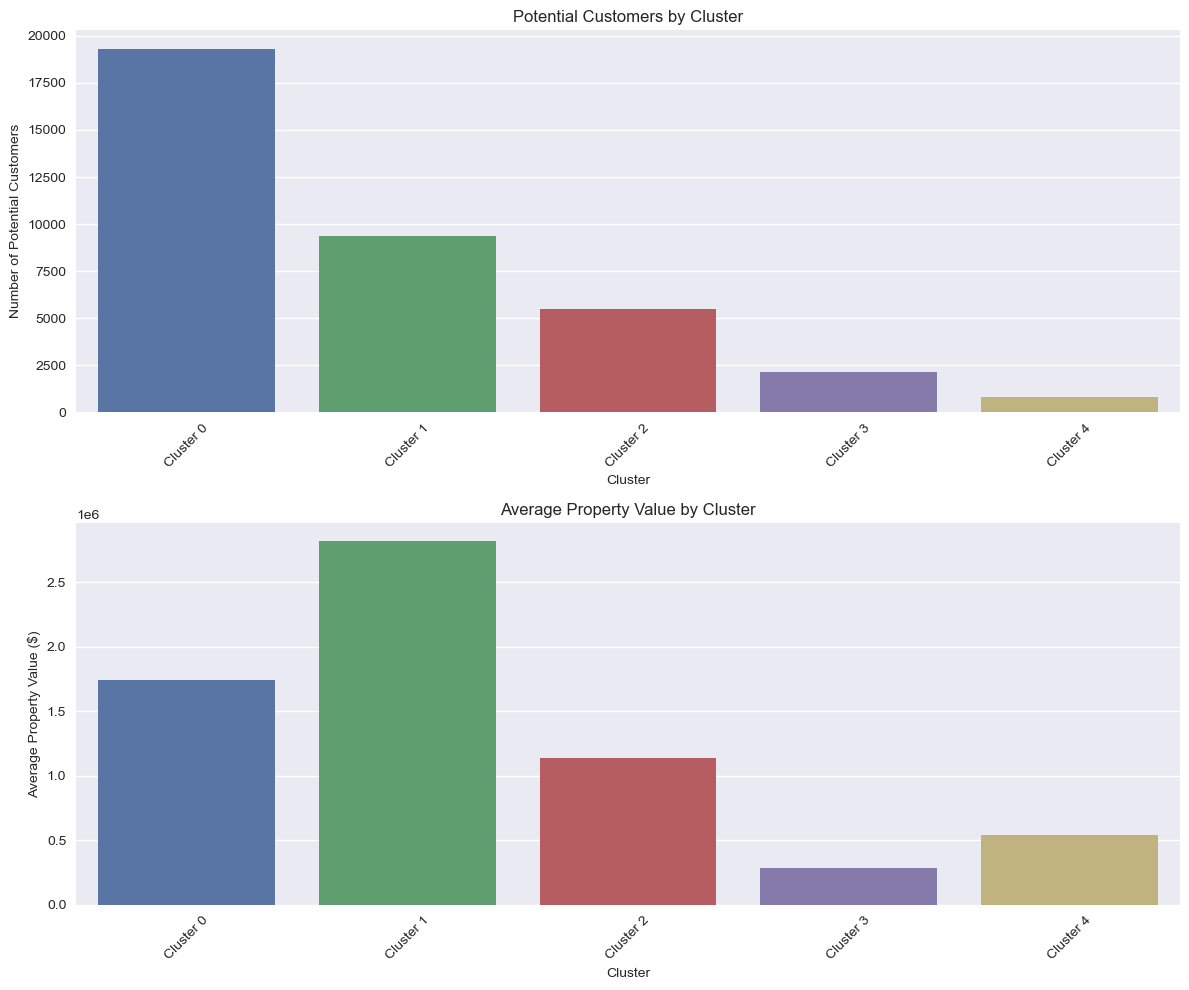

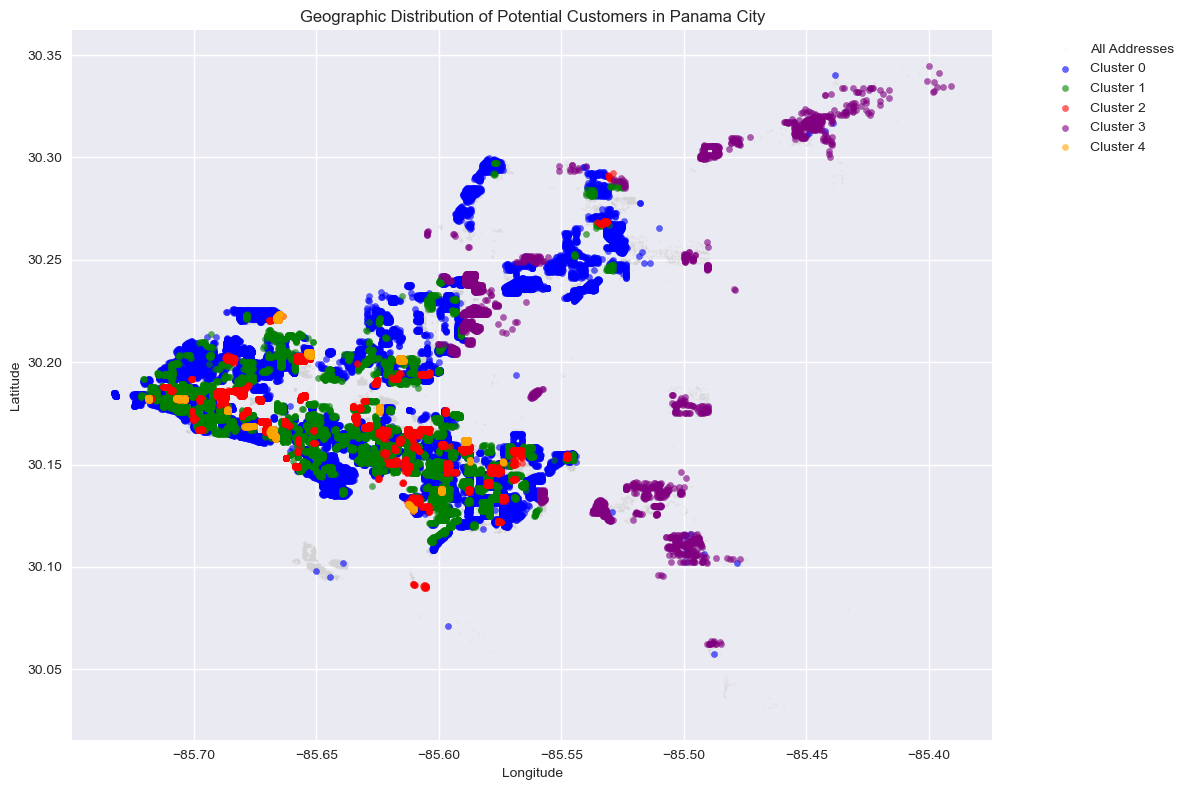

In [16]:
# Run the main analysis for Panama City potential customers
cluster_potentials, cluster_summary = analyze_panama_city_potential(nonExistingCustomers)

# Run the unserved segment analysis
unserved_segments, unserved_analysis = identify_unserved_segments(nonExistingCustomers, cluster_potentials)

# Print summary statistics for each cluster
print("\nPotential Customer Analysis by Cluster:")
print("-" * 50)
for cluster, stats in cluster_summary.items():
    print(f"\n{cluster}:")
    print(f"Number of potential customers: {stats['count']}")
    print(f"Average living space: {stats['avg_living_sqft']:.2f} sq ft")
    print(f"Average property value: ${stats['avg_sale_amount']:,.2f}")
    
    print("\nTop Property Types:")
    for prop_type, count in list(stats['property_types'].items())[:3]:
        print(f"- {prop_type}: {count}")
        
    print("\nTop Income Levels:")
    for income, count in list(stats['income_levels'].items())[:3]:
        print(f"- {income}: {count}")

# Print unserved segment analysis
print("\nUnserved Segment Analysis:")
print("-" * 50)
print(f"Total unserved addresses: {unserved_analysis['count']}")

print("\nTop Property Types in Unserved Segments:")
for prop_type, count in list(unserved_analysis['property_types'].items())[:3]:
    print(f"- {prop_type}: {count}")

print("\nTop Income Levels in Unserved Segments:")
for income, count in list(unserved_analysis['income_levels'].items())[:3]:
    print(f"- {income}: {count}")

# Create a summary DataFrame for visualization
cluster_summary_df = pd.DataFrame({
    'Cluster': list(cluster_summary.keys()),
    'Potential_Customers': [stats['count'] for stats in cluster_summary.values()],
    'Avg_Living_Space': [stats['avg_living_sqft'] for stats in cluster_summary.values()],
    'Avg_Property_Value': [stats['avg_sale_amount'] for stats in cluster_summary.values()]
})

# Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('seaborn')
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot potential customers by cluster
sns.barplot(data=cluster_summary_df, x='Cluster', y='Potential_Customers', ax=axes[0])
axes[0].set_title('Potential Customers by Cluster')
axes[0].set_ylabel('Number of Potential Customers')
axes[0].tick_params(axis='x', rotation=45)

# Plot average property values by cluster
sns.barplot(data=cluster_summary_df, x='Cluster', y='Avg_Property_Value', ax=axes[1])
axes[1].set_title('Average Property Value by Cluster')
axes[1].set_ylabel('Average Property Value ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save detailed results to CSV files for further analysis
for cluster_name, cluster_data in cluster_potentials.items():
    filename = f'../data/potentialCustomer/panama_city_potential_customers_{cluster_name.lower().replace(" ", "_")}.csv'
    cluster_data.to_csv(filename)

unserved_segments.to_csv('../data/potentialCustomer/panama_city_unserved_segments.csv')

# Create geographic visualization for Panama City
plt.figure(figsize=(12, 8))
plt.scatter(nonExistingCustomers['LON'], nonExistingCustomers['LAT'], 
           c='lightgray', alpha=0.3, s=1, label='All Addresses')

colors = ['blue', 'green', 'red', 'purple', 'orange']
for (cluster_name, cluster_data), color in zip(cluster_potentials.items(), colors):
    plt.scatter(cluster_data['LON'], cluster_data['LAT'],
               c=color, alpha=0.6, s=20, label=cluster_name)

plt.title('Geographic Distribution of Potential Customers in Panama City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Create data for clusters
clusters_data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
    'Customers': [19325, 9343, 5490, 2142, 808],
    'Avg_Living_Space': [2333.10, 18313.46, 23434.01, 1822.42, 9038.05],
    'Avg_Property_Value': [1740591.84, 2819671.03, 1140770.44, 283555.00, 542135.31],
    'Label': ['Moderate Economic Households', 'Luxury Estates', 'Mixed Properties', 
             'Affordable Homes', 'Urban Townhouses']
}

df = pd.DataFrame(clusters_data)

def format_currency(x, p):
    return f'${x:,.0f}'

def format_sqft(x, p):
    return f'{x:,.0f} sq ft'

# 1. Market Distribution Pie Chart
plt.figure(figsize=(12, 8))
plt.pie(df['Customers'], labels=df['Label'], autopct='%1.1f%%', 
        startangle=90, explode=[0.05]*5)
plt.title('Market Distribution by Cluster', pad=20, size=14)
plt.axis('equal')
plt.savefig('../Visualization/market_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

# 2. Customer Count Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Label', y='Customers', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Potential Customers by Segment', pad=20, size=14)
plt.ylabel('Number of Customers')
plt.xlabel('')
plt.tight_layout()
plt.savefig('../Visualization/customer_count.png', bbox_inches='tight', dpi=300)
plt.close()

# 3. Property Values Comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='Avg_Property_Value', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Average Property Value by Segment', pad=20, size=14)
plt.ylabel('Average Property Value')
plt.xlabel('')
# Format y-axis to show millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_currency))
plt.tight_layout()
plt.savefig('property_values.png', bbox_inches='tight', dpi=300)
plt.close()

# 4. Living Space Comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='Avg_Living_Space', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Average Living Space by Segment', pad=20, size=14)
plt.ylabel('Average Living Space (sq ft)')
plt.xlabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sqft))
plt.tight_layout()
plt.savefig('../Visualization/living_space.png', bbox_inches='tight', dpi=300)
plt.close()

# 5. Multi-metric Comparison
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot bars for customer count
ax1.bar(df['Label'], df['Customers'], alpha=0.3, color='blue', label='Customer Count')
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45, ha='right')

# Create second y-axis for property values
ax2 = ax1.twinx()
ax2.plot(df['Label'], df['Avg_Property_Value'], color='red', linewidth=2, 
         marker='o', label='Avg Property Value')
ax2.set_ylabel('Average Property Value ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_currency))

plt.title('Customer Count vs Property Value by Segment', pad=20, size=14)
fig.tight_layout()
plt.savefig('../Visualization/multi_metric.png', bbox_inches='tight', dpi=300)
plt.close()

# 6. Unserved Market Analysis
unserved_property_types = {
    'Single Family': 5030,
    'Not Classified': 3876,
    'Mixed Properties': 3219
}

unserved_income_levels = {
    'Not Classified': 3876,
    'Bottom 30-49.99%': 3734,
    'Bottom 10-19.99%': 3628
}

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Property Types Plot
ax1.pie(unserved_property_types.values(), labels=unserved_property_types.keys(), 
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Unserved Market - Property Types')

# Income Levels Plot
ax2.pie(unserved_income_levels.values(), labels=unserved_income_levels.keys(), 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Unserved Market - Income Levels')

plt.suptitle('Analysis of Unserved Market (17,223 Properties)', size=14, y=1.05)
plt.tight_layout()
plt.savefig('../Visualization/unserved_market.png', bbox_inches='tight', dpi=300)
plt.close()

# 7. Create a heatmap of key metrics
# Normalize the data for better visualization
metrics_data = df[['Customers', 'Avg_Living_Space', 'Avg_Property_Value']].copy()
metrics_normalized = (metrics_data - metrics_data.min()) / (metrics_data.max() - metrics_data.min())

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_normalized.T, annot=False, cmap='YlOrRd', 
            xticklabels=df['Label'], yticklabels=['Customers', 'Living Space', 'Property Value'])
plt.xticks(rotation=45, ha='right')
plt.title('Relative Comparison of Key Metrics Across Segments', pad=20, size=14)
plt.tight_layout()
plt.savefig('../Visualization/metrics_heatmap.png', bbox_inches='tight', dpi=300)
plt.close()

# Print completion message
print("All visualizations have been generated and saved as PNG files:")
print("1. market_distribution.png - Pie chart of market distribution")
print("2. customer_count.png - Bar chart of customer counts")
print("3. property_values.png - Bar chart of property values")
print("4. living_space.png - Bar chart of living spaces")
print("5. multi_metric.png - Combined chart of customers and property values")
print("6. unserved_market.png - Analysis of unserved market")
print("7. metrics_heatmap.png - Heatmap of key metrics")

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/2445234721.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


All visualizations have been generated and saved as PNG files:
1. market_distribution.png - Pie chart of market distribution
2. customer_count.png - Bar chart of customer counts
3. property_values.png - Bar chart of property values
4. living_space.png - Bar chart of living spaces
5. multi_metric.png - Combined chart of customers and property values
6. unserved_market.png - Analysis of unserved market
7. metrics_heatmap.png - Heatmap of key metrics


In [27]:
import folium
from folium import plugins

def create_panama_city_map(nonExistingCustomers, cluster_potentials):
    # Create a base map centered on Panama City, FL
    panama_city_center = [30.1588, -85.6602]
    m = folium.Map(location=panama_city_center, 
                  zoom_start=12,
                  tiles='cartodbpositron')
    
    # Define cluster labels and colors
    cluster_labels = {
        'Cluster 0': 'Moderate Economic Households',
        'Cluster 1': 'Luxury Estates',
        'Cluster 2': 'Mixed Properties',
        'Cluster 3': 'Affordable Homes',
        'Cluster 4': 'Urban Townhouses'
    }
    
    colors = {
        'Moderate Economic Households': 'blue',
        'Luxury Estates': 'green',
        'Mixed Properties': 'red',
        'Affordable Homes': 'purple',
        'Urban Townhouses': 'orange'
    }
    
    # Create a marker cluster for each cluster type
    marker_clusters = {
        label: plugins.MarkerCluster(name=label)
        for label in cluster_labels.values()
    }
    
    # Add points for each cluster
    for cluster_name, cluster_data in cluster_potentials.items():
        label = cluster_labels[cluster_name]
        for idx, row in cluster_data.iterrows():
            folium.CircleMarker(
                location=[row['LAT'], row['LON']],
                radius=3,
                color=colors[label],
                fill=True,
                popup=f"""
                <b>Segment:</b> {label}<br>
                <b>Address:</b> {row['ADD_NUMBER']} {row['STREETNAME']}<br>
                <b>Property Type:</b> {row['psyte_propertyTypeVariable.description']}<br>
                <b>Living Space:</b> {row['LivingSquareFootage']:.0f} sq ft
                """,
            ).add_to(marker_clusters[label])
    
    # Add all marker clusters to the map
    for cluster in marker_clusters.values():
        cluster.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add a title
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 300px; height: 90px; 
                z-index:9999; background-color: white; 
                border-radius: 10px; padding: 10px;
                font-size: 16px; font-weight: bold;
                text-align: center;">
        <h4>Market Segments in Panama City</h4>
        Click layers to toggle different segments
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px;
                z-index:9999; background-color: white;
                border-radius: 10px; padding: 10px;">
        <p style="text-align: center;"><b>Market Segments</b></p>
    '''
    
    for label, color in colors.items():
        legend_html += f'''
        <p>
            <span style="color: {color};">●</span> {label}
        </p>
        '''
    
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create the map
panama_city_map = create_panama_city_map(nonExistingCustomers, cluster_potentials)

# Save the map to an HTML file
panama_city_map.save('../Visualization/panama_city_market_segments.html')

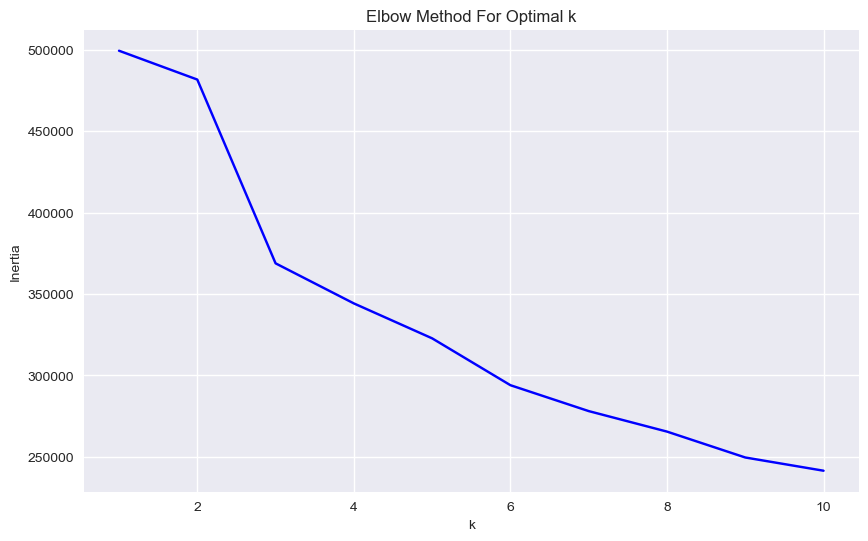

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/3583457746.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unserved['NewCluster'] = kmeans.fit_predict(features_scaled)
/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/3583457746.py:114: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(224)


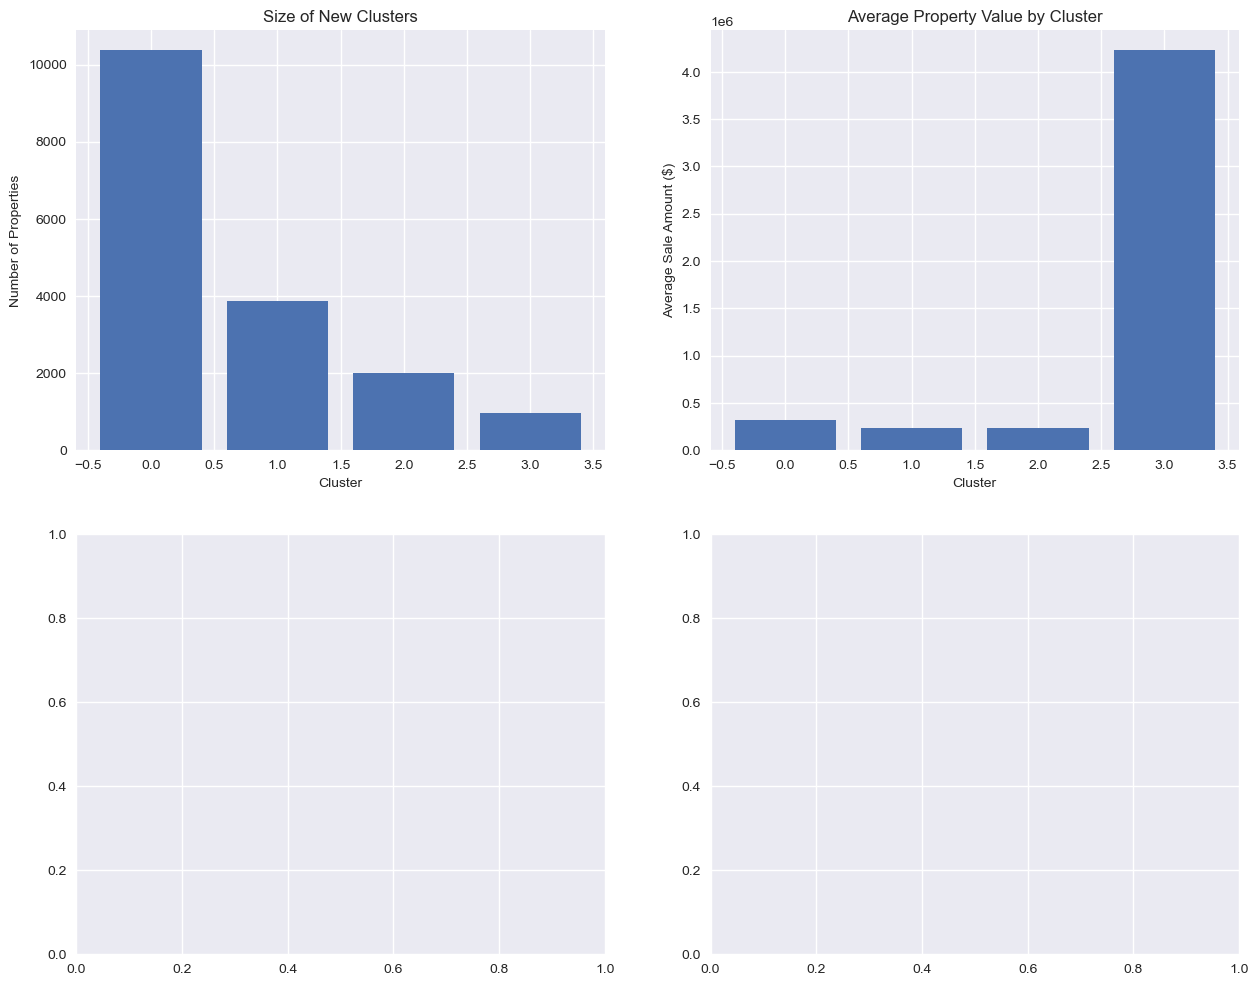

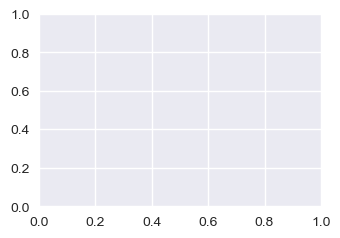

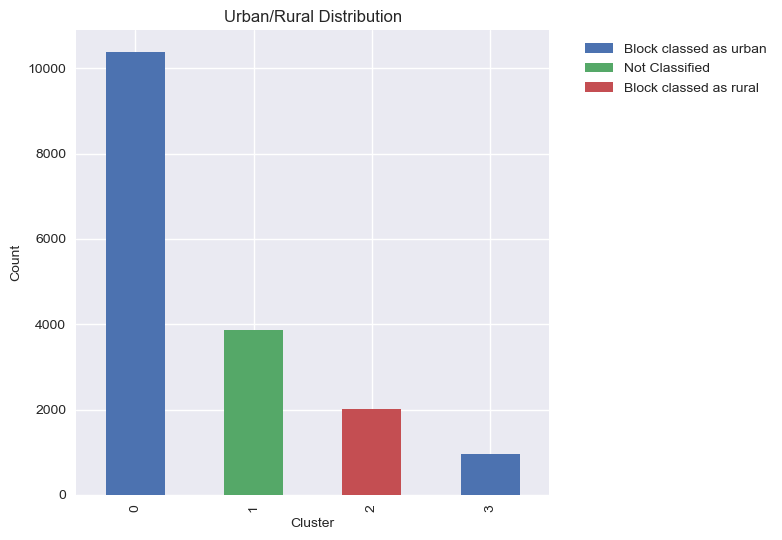


New Market Opportunity Analysis:
--------------------------------------------------

New_Cluster_0:
Size: 10372 properties
Average living space: 2900 sq ft
Average property value: $314,940.73
Average bedrooms: 3.0

Top Property Types:
- Majority of properties single family residences: 3992
- Mixed property types: 2909
- Majority of properties mobile / manufactured homes: 2350

Top Income Levels:
- Bottom 10-19.99% of households by household income: 3339
- Top 30-50% of households by household income: 2532
- Bottom 30-49.99% of households by household income: 2532

Urban/Rural Split:
- Block classed as urban: 10372

New_Cluster_1:
Size: 3876 properties
Average living space: 17253 sq ft
Average property value: $231,739.04
Average bedrooms: 4.1

Top Property Types:
- Not Classified: 3876

Top Income Levels:
- Not Classified: 3876

Urban/Rural Split:
- Not Classified: 3876

New_Cluster_2:
Size: 2014 properties
Average living space: 1813 sq ft
Average property value: $237,196.09
Average be

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_unserved_segments(nonExistingCustomers, cluster_potentials):
    # First, identify unserved addresses
    all_clustered_indices = set()
    for cluster_data in cluster_potentials.values():
        all_clustered_indices.update(cluster_data.index)
    
    unserved = nonExistingCustomers[~nonExistingCustomers.index.isin(all_clustered_indices)]
    
    # Create feature matrix for clustering
    features = pd.DataFrame()
    
    # Add numerical features
    numerical_features = [
        'LivingSquareFootage',
        'BedroomCount',
        'BathroomCount',
        'SaleAmount',
        'ParcelArea',
        'BuildingArea'
    ]
    
    features[numerical_features] = unserved[numerical_features]
    
    # Add encoded categorical features
    categorical_features = [
        'psyte_propertyTypeVariable.description',
        'psyte_propertyTenureVariable.description',
        'psyte_urbanRuralVariable.description',
        'psyte_householdIncomeVariable.description'
    ]
    
    # One-hot encode categorical variables
    for feature in categorical_features:
        dummies = pd.get_dummies(unserved[feature], prefix=feature.split('.')[0])
        features = pd.concat([features, dummies], axis=1)
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Determine optimal number of clusters using elbow method
    inertias = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    # Perform clustering with optimal k (let's say k=4 for this example)
    kmeans = KMeans(n_clusters=4, random_state=42)
    unserved['NewCluster'] = kmeans.fit_predict(features_scaled)
    
    # Analyze new clusters
    cluster_analysis = {}
    for cluster in range(kmeans.n_clusters):
        cluster_data = unserved[unserved['NewCluster'] == cluster]
        
        cluster_analysis[f'New_Cluster_{cluster}'] = {
            'size': len(cluster_data),
            'avg_living_space': cluster_data['LivingSquareFootage'].mean(),
            'avg_sale_amount': cluster_data['SaleAmount'].mean(),
            'avg_bedrooms': cluster_data['BedroomCount'].mean(),
            'property_types': cluster_data['psyte_propertyTypeVariable.description'].value_counts().to_dict(),
            'income_levels': cluster_data['psyte_householdIncomeVariable.description'].value_counts().to_dict(),
            'urban_rural': cluster_data['psyte_urbanRuralVariable.description'].value_counts().to_dict(),
            'tenure': cluster_data['psyte_propertyTenureVariable.description'].value_counts().to_dict()
        }
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cluster sizes
    sizes = [analysis['size'] for analysis in cluster_analysis.values()]
    plt.subplot(221)
    plt.bar(range(len(sizes)), sizes)
    plt.title('Size of New Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Properties')
    
    # Plot 2: Average property values
    avg_values = [analysis['avg_sale_amount'] for analysis in cluster_analysis.values()]
    plt.subplot(222)
    plt.bar(range(len(avg_values)), avg_values)
    plt.title('Average Property Value by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Sale Amount ($)')
    
    # Plot 3: Property types distribution
    property_types = pd.DataFrame([analysis['property_types'] for analysis in cluster_analysis.values()]).fillna(0)
    plt.subplot(223)
    property_types.plot(kind='bar', stacked=True)
    plt.title('Property Types Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 4: Urban/Rural distribution
    urban_rural = pd.DataFrame([analysis['urban_rural'] for analysis in cluster_analysis.values()]).fillna(0)
    plt.subplot(224)
    urban_rural.plot(kind='bar', stacked=True)
    plt.title('Urban/Rural Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return unserved, cluster_analysis

# Run the analysis
unserved_df, new_cluster_analysis = analyze_unserved_segments(nonExistingCustomers, cluster_potentials)

# Print detailed analysis
print("\nNew Market Opportunity Analysis:")
print("-" * 50)
for cluster_name, analysis in new_cluster_analysis.items():
    print(f"\n{cluster_name}:")
    print(f"Size: {analysis['size']} properties")
    print(f"Average living space: {analysis['avg_living_space']:.0f} sq ft")
    print(f"Average property value: ${analysis['avg_sale_amount']:,.2f}")
    print(f"Average bedrooms: {analysis['avg_bedrooms']:.1f}")
    
    print("\nTop Property Types:")
    for prop_type, count in list(analysis['property_types'].items())[:3]:
        print(f"- {prop_type}: {count}")
    
    print("\nTop Income Levels:")
    for income, count in list(analysis['income_levels'].items())[:3]:
        print(f"- {income}: {count}")
    
    print("\nUrban/Rural Split:")
    for location, count in analysis['urban_rural'].items():
        print(f"- {location}: {count}")

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/1572817080.py:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_70697/1572817080.py:114: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)



Unserved Market Segment Summary:
--------------------------------------------------

Urban Mixed Housing:
Size: 10372 properties
Average living space: 2900 sq ft
Average property value: $314,940.73
Average bedrooms: 3.0
Location: Urban

Large Unclassified Properties:
Size: 3876 properties
Average living space: 17253 sq ft
Average property value: $231,739.04
Average bedrooms: 4.1
Location: Not Classified

Rural Family Homes:
Size: 2014 properties
Average living space: 1813 sq ft
Average property value: $237,196.09
Average bedrooms: 3.2
Location: Rural

Luxury Urban Apartments:
Size: 961 properties
Average living space: 24496 sq ft
Average property value: $4,228,386.06
Average bedrooms: 2.5
Location: Urban


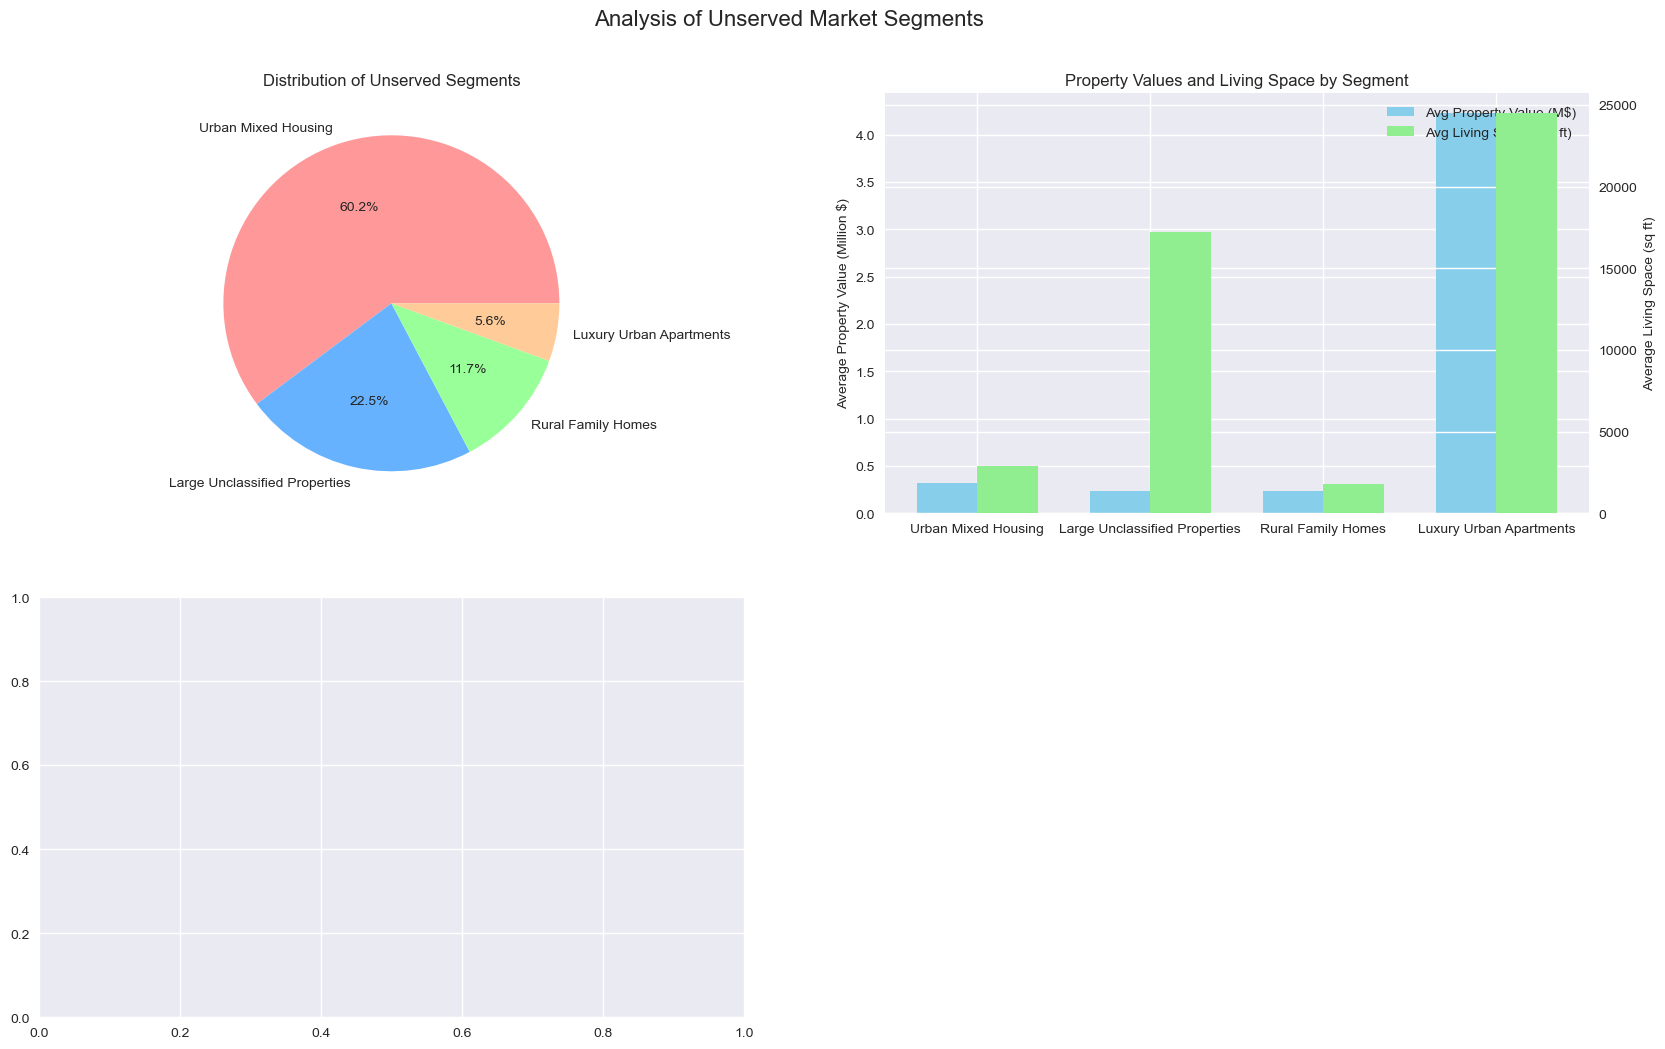

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create descriptive names based on characteristics
unserved_clusters = {
    'Urban Mixed Housing': {  # New_Cluster_0
        'size': 10372,
        'avg_living_space': 2900,
        'avg_property_value': 314940.73,
        'avg_bedrooms': 3.0,
        'property_types': {
            'Single Family': 3992,
            'Mixed': 2909,
            'Mobile/Manufactured': 2350
        },
        'location': 'Urban'
    },
    'Large Unclassified Properties': {  # New_Cluster_1
        'size': 3876,
        'avg_living_space': 17253,
        'avg_property_value': 231739.04,
        'avg_bedrooms': 4.1,
        'property_types': {
            'Not Classified': 3876
        },
        'location': 'Not Classified'
    },
    'Rural Family Homes': {  # New_Cluster_2
        'size': 2014,
        'avg_living_space': 1813,
        'avg_property_value': 237196.09,
        'avg_bedrooms': 3.2,
        'property_types': {
            'Single Family': 1038,
            'Mobile/Manufactured': 574,
            'Mixed': 310
        },
        'location': 'Rural'
    },
    'Luxury Urban Apartments': {  # New_Cluster_3
        'size': 961,
        'avg_living_space': 24496,
        'avg_property_value': 4228386.06,
        'avg_bedrooms': 2.5,
        'property_types': {
            'Low-rise Condos/Apartments': 961
        },
        'location': 'Urban'
    }
}

# Set style
plt.style.use('seaborn')
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Analysis of Unserved Market Segments', fontsize=16, y=0.95)

# 1. Market Size Distribution
plt.subplot(2, 2, 1)
sizes = [cluster['size'] for cluster in unserved_clusters.values()]
labels = unserved_clusters.keys()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Unserved Segments')

# 2. Property Values and Living Space
plt.subplot(2, 2, 2)
x = np.arange(len(unserved_clusters))
width = 0.35

ax1 = plt.gca()
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, 
                [cluster['avg_property_value']/1000000 for cluster in unserved_clusters.values()],
                width, label='Avg Property Value (M$)', color='skyblue')
bars2 = ax2.bar(x + width/2, 
                [cluster['avg_living_space'] for cluster in unserved_clusters.values()],
                width, label='Avg Living Space (sq ft)', color='lightgreen')

ax1.set_ylabel('Average Property Value (Million $)')
ax2.set_ylabel('Average Living Space (sq ft)')
plt.title('Property Values and Living Space by Segment')
plt.xticks(x, labels, rotation=45, ha='right')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 3. Property Type Distribution
plt.subplot(2, 2, 3)
property_data = []
for name, cluster in unserved_clusters.items():
    for prop_type, count in cluster['property_types'].items():
        property_data.append({
            'Segment': name,
            'Property Type': prop_type,
            'Count': count
        })

df_properties = pd.DataFrame(property_data)
property_pivot = df_properties.pivot(index='Segment', columns='Property Type', values='Count')
property_pivot.plot(kind='bar', stacked=True)
plt.title('Property Type Distribution by Segment')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Number of Properties')

# 4. Average Bedrooms and Location
plt.subplot(2, 2, 4)
locations = pd.DataFrame([{
    'Segment': name,
    'Bedrooms': cluster['avg_bedrooms'],
    'Location': cluster['location']
} for name, cluster in unserved_clusters.items()])

ax = sns.barplot(x='Segment', y='Bedrooms', data=locations, 
                hue='Location', palette='Set2')
plt.title('Average Bedrooms by Segment and Location')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Number of Bedrooms')

# Adjust layout
plt.tight_layout()
plt.savefig('unserved_segments_analysis.png', bbox_inches='tight', dpi=300)
plt.close()

# Print summary statistics
print("\nUnserved Market Segment Summary:")
print("-" * 50)
for name, cluster in unserved_clusters.items():
    print(f"\n{name}:")
    print(f"Size: {cluster['size']} properties")
    print(f"Average living space: {cluster['avg_living_space']:.0f} sq ft")
    print(f"Average property value: ${cluster['avg_property_value']:,.2f}")
    print(f"Average bedrooms: {cluster['avg_bedrooms']:.1f}")
    print(f"Location: {cluster['location']}")

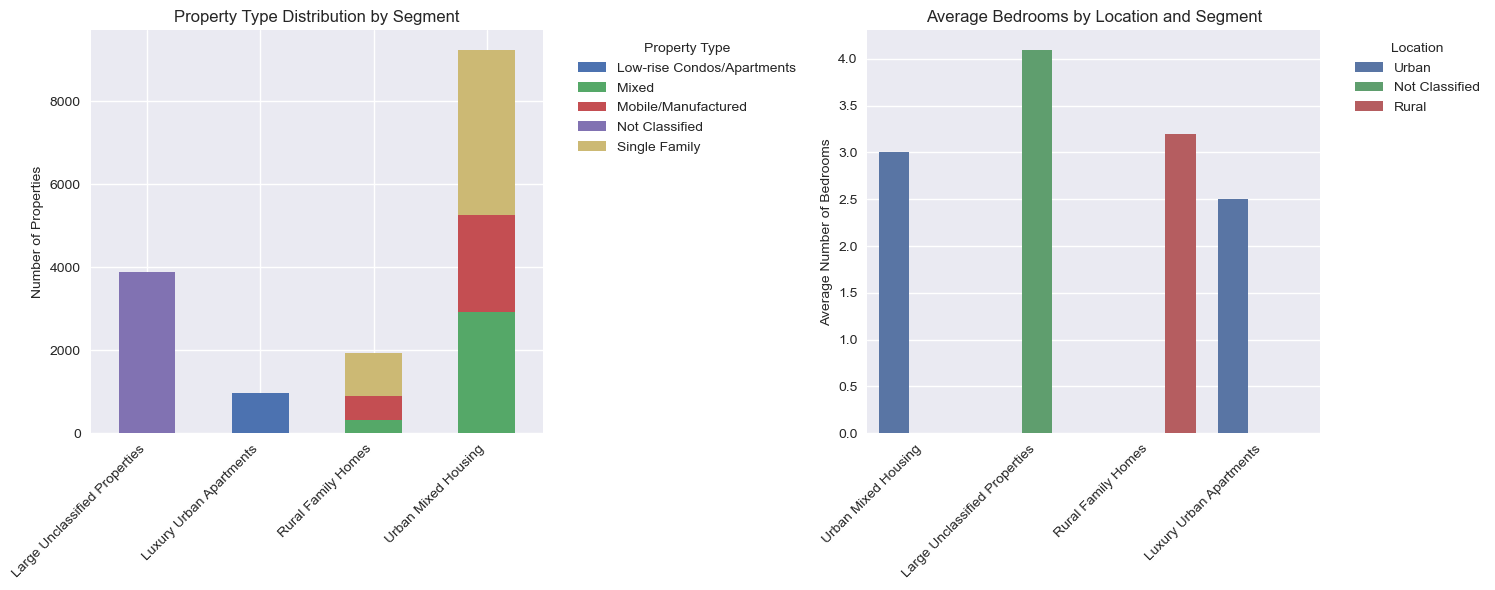


Property Type Distribution:
Segment
Large Unclassified Properties    3876
Luxury Urban Apartments           961
Rural Family Homes               1922
Urban Mixed Housing              9251
Name: Count, dtype: int64

Average Bedrooms by Segment and Location:
                         Segment  Bedrooms        Location
0            Urban Mixed Housing       3.0           Urban
1  Large Unclassified Properties       4.1  Not Classified
2             Rural Family Homes       3.2           Rural
3        Luxury Urban Apartments       2.5           Urban


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define the data
unserved_clusters = {
    'Urban Mixed Housing': {
        'property_types': {
            'Single Family': 3992,
            'Mixed': 2909,
            'Mobile/Manufactured': 2350
        },
        'avg_bedrooms': 3.0,
        'location': 'Urban'
    },
    'Large Unclassified Properties': {
        'property_types': {
            'Not Classified': 3876
        },
        'avg_bedrooms': 4.1,
        'location': 'Not Classified'
    },
    'Rural Family Homes': {
        'property_types': {
            'Single Family': 1038,
            'Mobile/Manufactured': 574,
            'Mixed': 310
        },
        'avg_bedrooms': 3.2,
        'location': 'Rural'
    },
    'Luxury Urban Apartments': {
        'property_types': {
            'Low-rise Condos/Apartments': 961
        },
        'avg_bedrooms': 2.5,
        'location': 'Urban'
    }
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Property Type Distribution
property_data = []
for segment, data in unserved_clusters.items():
    for prop_type, count in data['property_types'].items():
        property_data.append({
            'Segment': segment,
            'Property Type': prop_type,
            'Count': count
        })

df_properties = pd.DataFrame(property_data)

# Create the stacked bar chart
pivot_table = df_properties.pivot(index='Segment', columns='Property Type', values='Count')
pivot_table.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Property Type Distribution by Segment')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Properties')
ax1.legend(title='Property Type', bbox_to_anchor=(1.05, 1))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Average Bedrooms by Location
bedroom_data = []
for segment, data in unserved_clusters.items():
    bedroom_data.append({
        'Segment': segment,
        'Bedrooms': data['avg_bedrooms'],
        'Location': data['location']
    })

df_bedrooms = pd.DataFrame(bedroom_data)

# Create the grouped bar chart
sns.barplot(x='Segment', y='Bedrooms', hue='Location', data=df_bedrooms, ax=ax2)
ax2.set_title('Average Bedrooms by Location and Segment')
ax2.set_xlabel('')
ax2.set_ylabel('Average Number of Bedrooms')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(title='Location', bbox_to_anchor=(1.05, 1))

# Adjust layout
plt.tight_layout()
plt.savefig('property_and_bedroom_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

# Print summary for verification
print("\nProperty Type Distribution:")
print(df_properties.groupby('Segment')['Count'].sum())

print("\nAverage Bedrooms by Segment and Location:")
print(df_bedrooms[['Segment', 'Bedrooms', 'Location']])